In [1]:
# Standard Imports
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import scipy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import os
import glob
import seaborn as sns
import warnings
import datetime
import dask
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
dask.config.set(scheduler='threads')

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
def load_grid_info(grid_file=None, model=None):
    grid = xr.open_dataset(grid_file)
    n_lat = np.rad2deg(grid.grid_center_lat.values.reshape(tuple(np.flip(grid.grid_dims.T.values,0)))) # Reshape
    n_lon = np.rad2deg(grid.grid_center_lon.values.reshape(tuple(np.flip(grid.grid_dims.T.values,0)))) # Reshape
    grid_imask = grid.grid_imask.values.reshape(tuple(np.flip(grid.grid_dims.T.values,0))) # Reshape

    nj = xr.DataArray(np.arange(0,n_lat.shape[0],1), dims=('nj')) # Make indices
    ni = xr.DataArray(np.arange(0,n_lat.shape[1],1), dims=('ni'))
    lat = xr.DataArray(n_lat, dims=('nj','ni'), coords={'nj':nj, 'ni':ni})
    lon = xr.DataArray(n_lon, dims=('nj','ni'), coords={'nj':nj, 'ni':ni})
    imask = xr.DataArray(grid_imask, dims=('nj','ni'), coords={'nj':nj, 'ni':ni}).astype('bool') # int to bool

    if model=='NSIDC':
        lat_b = cell_bounds_to_corners(gridinfo=grid, varname='grid_corner_lat')
        lon_b = cell_bounds_to_corners(gridinfo=grid, varname='grid_corner_lon')
    else:
        raise ValueError('model not found.')

    # Combine
    return xr.Dataset({'lat':lat, 'lon':lon, 'lat_b':lat_b, 'lon_b':lon_b, 'imask':imask})

def cell_bounds_to_corners(gridinfo=None, varname=None):
    ''' Some models/obs give the four corner lat/lons for each cell. xesmf needs the bounds N+1 grid, this
    converts the former to the later.'''
    
    # Add cell bound coords (lat_b and lon_b)
    n_j = gridinfo.grid_dims.values[1]
    n_i = gridinfo.grid_dims.values[0]
    nj_b = np.arange(0, n_j + 1) # indices of corner of cells
    ni_b = np.arange(0, n_i + 1)

    # Grab all corners as arrays
    dim_out = tuple(np.flip(gridinfo.grid_dims.transpose().values,0))
    ul = gridinfo[varname].isel(grid_corners=0).values.reshape(dim_out)
    ll = gridinfo[varname].isel(grid_corners=1).values.reshape(dim_out)
    lr = gridinfo[varname].isel(grid_corners=2).values.reshape(dim_out)
    ur = gridinfo[varname].isel(grid_corners=3).values.reshape(dim_out)

    # Merge together
    m1 = np.concatenate((ul, ur[:,0][:, None]), axis=1) # add on ur at right
    m2 = np.append(ll[-1,:], lr[-1,0])
    m3 = np.concatenate((m1, m2[:, None].T), axis=0) # add ll and lr to bottom
    ds_out = xr.DataArray(m3, dims=('nj_b', 'ni_b'), coords={'nj_b':nj_b, 'ni_b':ni_b})
    ds_out = xr.ufuncs.rad2deg( ds_out ) # rad to deg
    return ds_out


In [4]:
# FYI: We regrid the matrix with xe.Regridder(grid_in, grid_out, method)
# Regridding Options
# method='conservative_normed' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

# When regridding from low-resolution to high-resolution, bilinear and patch will produce smooth results, 
# while conservative and nearest_s2d will preserve the original coarse grid structure (although the data 
# is now de- fined on a finer grid.).
# nearest_d2s is quite different from others: One source point can be mapped to only one destination 
# point. Because we have far less source points (on a low-resolution grid) than destination points (on a high-resolution grid), most destination points cannot receive any data so they just have zero values. 
# Only the destination points that are closest to source points can receive data.


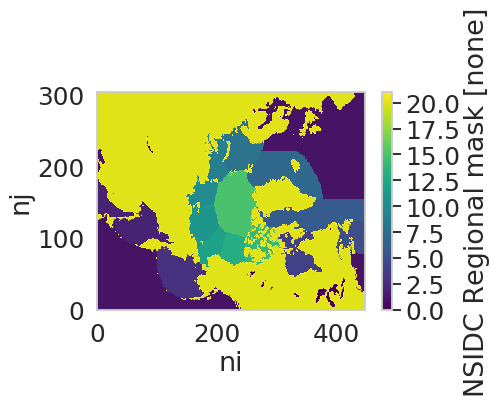

In [5]:
# input the NSIDC regions

nsidc_grid_file = 'stereo_gridinfo.nc'
nsidc_grid = load_grid_info(nsidc_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
nsidc_grid['lat_b'] = nsidc_grid.lat_b.where(nsidc_grid.lat_b < 90, other = 90)

nsidc_regions_file = 'NSIDC_Regions_Masks.nc'
nsidc_regions = xr.open_dataset(nsidc_regions_file)

nsidc_regions.rename({'nx':'nj','ny':'ni'}, inplace=True)
nsidc_regions.mask.plot()

In [6]:
nsidc_regions

<xarray.Dataset>
Dimensions:       (ni: 448, nj: 304, nregions: 21)
Dimensions without coordinates: ni, nj, nregions
Data variables:
    mask          (nj, ni) int32 ...
    lat           (nj, ni) float32 ...
    lon           (nj, ni) float32 ...
    area          (nj, ni) float32 ...
    region_names  (nregions) |S17 ...

In [7]:
nsidcthearea=np.zeros(21)
for nreg in nsidc_regions.nregions.values:
    nsidcthearea[nreg] = nsidc_regions.area.where(nsidc_regions.mask==nreg).sum(dim=('nj','ni')).values
nsidcthearea # in km x km


array([  335798.75  , 14853001.    ,  2207759.75  ,  2231437.25  ,
        1233463.625 ,   691208.5625,  2765305.    ,  2933018.    ,
        1674568.875 ,   918608.125 ,   872414.25  ,  1304342.75  ,
         830271.3125,   940219.375 ,   761228.25  ,  3224682.    ,
              0.    ,        0.    ,        0.    ,        0.    ,
       34965216.    ])

In [ ]:
models = [ 'GFDL-ESM4', 'MIROC-ES2L', 'MIROC6','CanESM5','CNRM-CM6-1',
          'CNRM-ESM2-1','EC-Earth3','EC-Earth3-Veg','IPSL-CM6A-LR','GFDL-CM4',
          'NorESM2-LM','SAM0-UNICON','UKESM1-0-LL','CAMS-CSM1-0','MRI-ESM2-0']
#models = ['CESM2','NESM3'] # worked on my laptop but not here, old netcdf library?
method = 'nearest_s2d'       #method = 'nearest_d2s'  # this was bad do not use

for model in models:
    model_area_file =  glob.glob('areacello_Ofx_'+model+'_*.nc')
    model_area_file = model_area_file[0]
    ds_model = xr.open_dataset(model_area_file)

    if model in ['NESM3','CESM2','GFDL-ESM4','GFDL-CM4']:
        ds_model=ds_model.rename({'lat_bnds':'lat_b','lon_bnds':'lon_b'})
    elif model in ['MRI-ESM2-0','CAMS-CSM1-0','MIROC-ES2L','MIROC6','CanESM5','EC-Earth3','EC-Earth3-Veg','NorESM2-LM','SAM0-UNICON','UKESM1-0-LL']:
        ds_model=ds_model.rename({'vertices_latitude':'lat_b','vertices_longitude':'lon_b'})
        ds_model=ds_model.rename({'latitude':'lat','longitude':'lon'})
    elif model in ['IPSL-CM6A-LR']:
        ds_model=ds_model.rename({'bounds_nav_lat':'lat_b','bounds_nav_lon':'lon_b'})
        ds_model=ds_model.rename({'nav_lat':'lat','nav_lon':'lon'})
        
    if model == 'NorESM2-LM':  # for some odd reason the latitude repeats at j=384 and 385
        ds_model=ds_model.isel(j=slice(0,384))  # so ditch it

    regridder = xe.Regridder(nsidc_grid, ds_model, method, periodic=False, reuse_weights=False)
    model_regions = regridder(nsidc_regions.mask)

    # get some sample data and use it to mask out the land on the model's grid
    model_sample_file = 'siconc_SImon_'+model+'_sample.nc'
    sic_model = xr.open_dataset(model_sample_file)
    sic_model = sic_model.siconc  
    sic_model=sic_model.squeeze()  # remove time dimension of length 1
    model_regions = model_regions.where(sic_model.values<120, other=np.nan)
    model_regions = model_regions.where(model_regions.lat.values>45, other = np.nan)

    # compute the maximum possible areas of each region so we can check later how much they vary
    thearea=np.zeros(21)
    horizdims = ds_model.areacello.dims
    for nreg in nsidc_regions.nregions.values:
        areacello_byreg=ds_model.areacello.where(model_regions==nreg)
        thearea[nreg] = areacello_byreg.sum(dim=horizdims).values
        #if model == 'CESM2':
        #    thearea[nreg] = areacello_byreg.sum(dim=('nlon','nlat')).values
        #else:
        #    thearea[nreg] = areacello_byreg.sum(dim=(horizdims).values

    # shove stuff into the xarray
    ds_model['region_names']=nsidc_regions.region_names
    ds_model['region_mask'] =model_regions
    ds_model['region_area'] =xr.DataArray(thearea*1e-6, dims='nregions') # in km x km
    ds_model['region_area_relative2NSIDC'] =xr.DataArray(thearea*1e-6/nsidcthearea, dims='nregions')

    outfile='regionmask_surfaceareacell_'+model+'.nc'
    ds_model.to_netcdf(outfile)

Create weight file: nearest_s2d_304x448_576x720.nc


[-80.11491141 -79.94175457 -79.76559632 -79.58638632 -79.40407348
 -79.21860597 -79.02993118 -78.83799571 -78.64274542 -78.44412535
 -78.24207979 -78.03655221 -77.82748529 -77.61482091 -77.39850015
 -77.17846329 -76.95464978 -76.72699829 -76.49544664 -76.25993188
 -76.02039022 -75.77675707 -75.52896701 -75.27695385 -75.02065056
 -74.75998934 -74.49490156 -74.22531782 -73.95116796 -73.672381
 -73.38888524 -73.10060819 -72.80747664 -72.50941664 -72.20635353
 -71.89821196 -71.58491589 -71.26638862 -70.94255281 -70.61333052
 -70.27864319 -69.93841173 -69.59255648 -69.24099731 -68.8836536
 -68.5204443  -68.15128797 -67.77610281 -67.39480671 -67.00731731
 -66.61355202 -66.2134281  -65.80686269 -65.3937729  -64.97407586
 -64.54768875 -64.11452893 -63.67451399 -63.22756178 -62.77359058
 -62.3125191  -61.84426662 -61.36875306 -60.8858991  -60.39562624
 -59.89785694 -59.39251474 -58.87952433 -58.3588117  -57.83030428
 -57.29393101 -56.74962254 -56.19731134 -55.63693181 -55.06842048
 -54.49171614

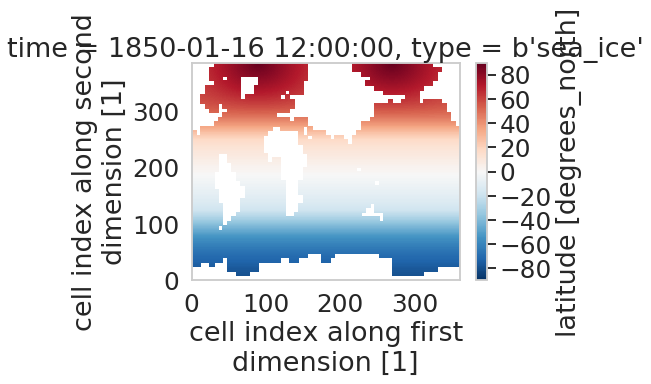

In [48]:
print(ds_model.lat.isel(i=300).values)
tmp = sic_model.latitude.where(sic_model.latitude.values<100, other=np.nan)
print(tmp.isel(i=300).values) # these are the same except ds_model has a repeated latitude at the NP
     # and sic_model has nans over land

tmp.plot()

## This plot shows us how the regional area mask of the models compares to the NSIDC regional area mask. Oddly the Central Arctic tends to be low in the models, not sure why.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 <a list of 18 Text xticklabel objects>)

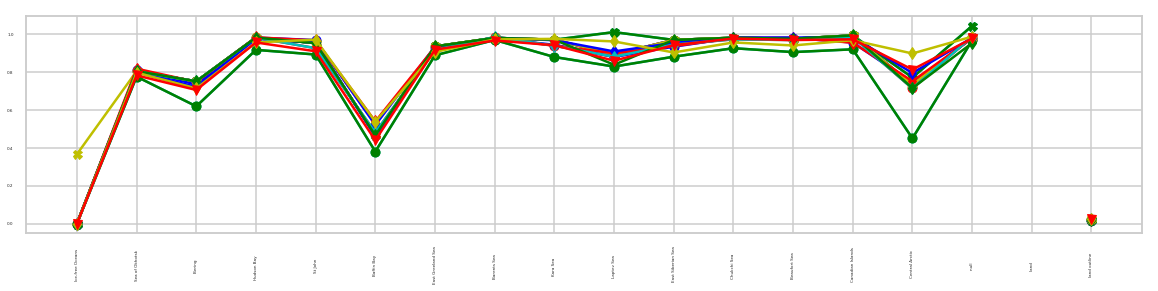

In [16]:
f = plt.figure(figsize=(20,4))
model_color = ['r','b','c','g','y','r','b','c','g','y','r','b','c','g','y','r','b','c','g','y']
model_marker = ['o','o','o','o','o','X','X','X','X','X','d','d','d','d','d','v','v','v','v','v']
models = ['CESM2', 'GFDL-ESM4', 'MIROC-ES2L', 'MIROC6','CanESM5','CNRM-CM6-1',
          'CNRM-ESM2-1','EC-Earth3','EC-Earth3-Veg','IPSL-CM6A-LR','GFDL-CM4',
          'NorESM2-LM','SAM0-UNICON','UKESM1-0-LL','CAMS-CSM1-0','MRI-ESM2-0']

#models=['CAMS-CSM1-0','MRI-ESM2-0']
for (im,model) in enumerate(models):
    cc=model_color[im]
    cm=model_marker[im]
    infile='regionmask_surfaceareacell_'+model+'.nc'
    ds_model = xr.open_dataset(infile)
    plt.plot(ds_model.region_names,ds_model.region_area_relative2NSIDC,  color=cc,
                        marker=cm, label=model)
plt.xticks(rotation=90)
#plt.legend()

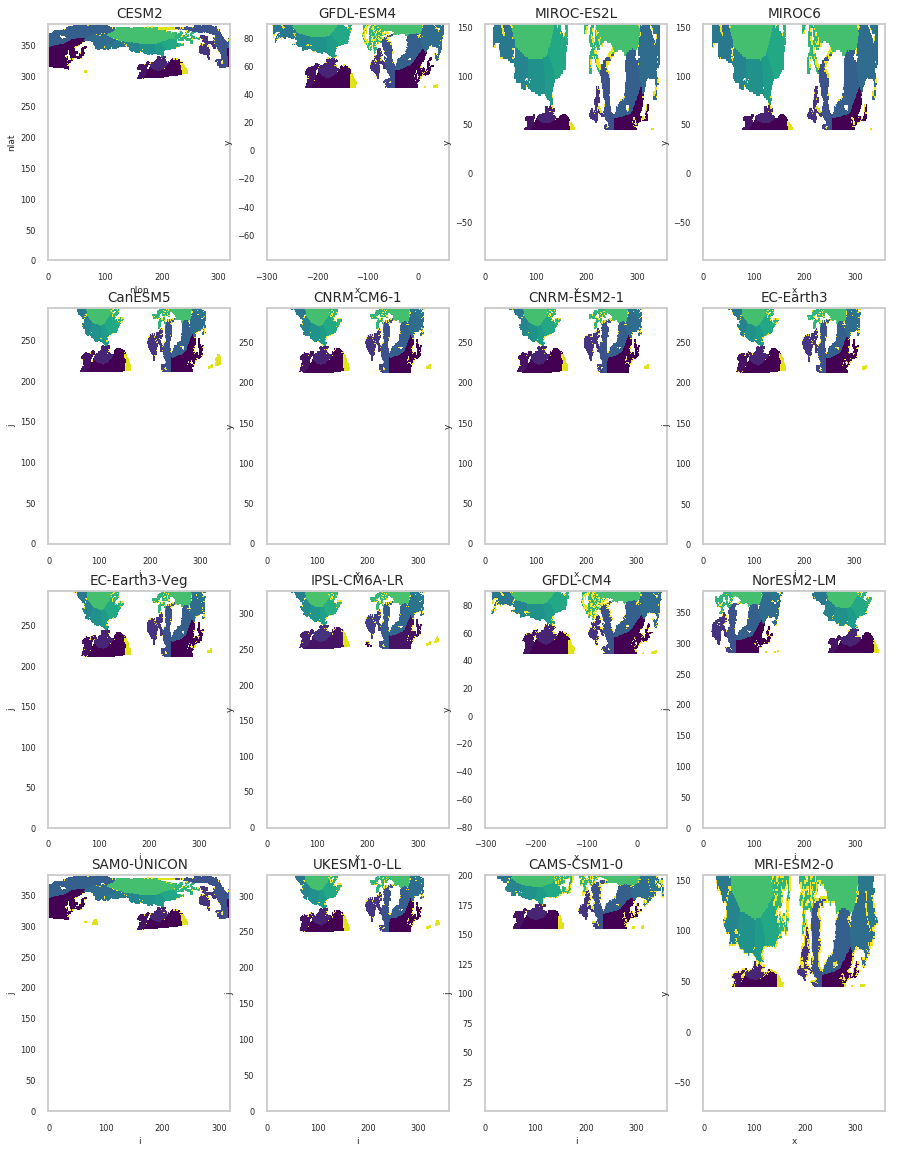

In [20]:
f, ax = plt.subplots(nrows=4,ncols=4)
f.set_size_inches(15,20)
ax = ax.reshape(-1)
sns.set_context("talk", font_scale=0.75, rc={"lines.linewidth": 2.5})
for (im,model) in enumerate(models):
    infile='regionmask_surfaceareacell_'+model+'.nc'
    ds_model = xr.open_dataset(infile)
    ds_model.region_mask.plot.pcolormesh( ax=ax[im], label=model ,add_colorbar=False)
    ax[im].set_title(model)
    
f.savefig('AllModelRegionMasks.png',bbox_inches='tight',dpi=200)
